<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/submit_moving33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
import os  # osモジュールをインポート
import tensorflow as tf
import numpy as np
import random

# シードを固定
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

# 決定論的な動作を確保するための設定
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # TensorFlowで決定論的な動作を保証
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # cuDNNで決定論的な動作を保証

In [4]:
df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

In [5]:
# 事前に作成した特徴量データをインポート
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")
df = merged_df.copy()

In [6]:
pd.set_option('display.max_columns', None)
df[:1917].describe()
# 2011-01-01 ~ 2016-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1891.000000,1891.000000,1917.0,1552.000000,1916.000000,1916.000000,1910.000000,1910.000000,1887.000000,1887.000000,1827.000000,1827.000000,1552.000000,1552.000000,1911.000000,1888.000000,1828.000000,1911.000000,1888.000000,1828.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1.917000e+03
mean,35.804903,0.107460,0.769953,0.525300,35.637599,0.249529,-0.082225,9.557925,41.804802,43.927762,44.016278,1.0,33.386598,0.767745,0.523486,0.756021,0.511518,0.745098,0.498145,0.752600,0.504652,0.771263,0.525129,0.766166,0.758651,0.752747,0.521716,0.510876,0.505191,2013.141888,6.308816,15.725613,2.999478,25.718832,2.699531,0.285863,0.032864,0.032864,2.437141,0.010955,0.010955,0.003130,0.002608,1.0,2.514345,3.498174,0.018258,0.010433,0.017214,526612.188445,4.119433,97.772238,101.879874,101.142499,99.264799,3.000000e-01
std,17.262632,0.309777,1.057716,0.914971,9.280903,12.925255,5.035453,3.104678,3.044833,11.447007,11.242253,0.0,16.148330,1.053565,0.911758,1.033819,0.887385,1.027819,0.871288,1.032913,0.876463,1.066396,0.909517,0.775024,0.533381,0.336354,0.684850,0.469456,0.286153,1.520803,3.505973,8.800553,2.000913,15.330926,1.268893,0.451943,0.178327,0.178327,1.136709,0.104117,0.104117,0.055872,0.051018,0.0,1.138356,1.708270,0.133917,0.101634,0.130103,10227.154958,0.513904,1.736938,2.430198,0.678858,0.292215,2.165500e-15
min,0.000000,0.000000,-1.000000,-1.000000,18.100942,-47.954564,-27.424270,-2.000000,40.748571,34.931429,36.864745,1.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,-0.066667,0.266667,-0.571429,-0.100000,0.133333,2011.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,503949.300000,3.400000,95.698650,98.808200,99.387086,98.893476,3.000000e-01
25%,23.000000,0.000000,0.000000,0.000000,27.808185,-7.709907,-3.325194,7.591663,40.748571,34.931429,36.864745,1.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.466667,0.544444,0.142857,0.266667,0.322222,2012.000000,3.000000,8.000000,1.000000,12.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,517290.437363,3.632258,96.275557,99.766675,100.609987,99.091660,3.000000e-01
50%,34.000000,0.000000,0.000000,0.000000,39.861618,-0.911151,-0.201739,9.661904,40.748571,34.931429,36.864745,1.0,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.600000,0.611111,0.285714,0.366667,0.366667,2013.000000,6.000000,16.000000,3.000000,25.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000,3.000000,0.000000,0.000000,0.000000,527621.807609,4.138710,96.966314,101.591800,101.188638,99.1

In [7]:
pd.set_option('display.max_columns', None)
df[1917:].describe()
# 2016-04-01 ~ 2017-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,0.0,365.000000,365.000000,365.000000,0.0,0.0,0.0,0.0,365.000000,360.000000,360.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,NaN,0.452055,0.794521,0.586301,NaN,NaN,NaN,NaN,45.191863,44.248109,44.868842,0.0,46.087671,0.794521,0.586301,0.800000,0.594521,0.786301,0.572603,0.780822,0.564384,0.764384,0.526027,0.798434,0.795068,0.787245,0.590215,0.583927,0.571385,2016.246575,6.526027,15.720548,3.002740,26.463014,2.698630,0.284932,0.032877,0.032877,2.509589,0.010959,0.010959,0.002740,0.002740,1.0,2.490411,3.515068,0.019178,0.010959,0.016438,544332.606986,3.167945,99.974418,108.485682,102.799637,98.918724,3.000000e-01
std,NaN,0.498379,1.002180,0.958667,NaN,NaN,NaN,NaN,4.898618,10.775812,11.770860,0.0,18.069098,1.002180,0.958667,1.019588,0.986153,1.012737,0.951179,1.008842,0.937229,1.021388,0.939082,0.755868,0.552362,0.343597,0.775468,0.582155,0.354027,0.431609,3.452584,8.808321,2.000685,15.024956,1.269734,0.452001,0.178559,0.178559,1.118300,0.104252,0.104252,0.052342,0.052342,0.0,1.118300,1.712244,0.137339,0.104252,0.127329,2658.157620,0.116446,0.218077,1.382975,0.233800,0.061306,1.834383e-15
min,NaN,0.000000,-1.000000,-1.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,0.033333,0.400000,-0.571429,-0.066667,0.244444,2016.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,541020.600000,2.900000,99.669130,106.808900,102.316374,98.794385,3.000000e-01
25%,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.500000,0.577778,0.285714,0.333333,0.333333,2016.000000,4.000000,8.000000,1.000000,13.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,542199.100000,3.100000,99.845592,107.402463,102.638977,98.893476,3.000000e-01
50%,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,47.388646,36.864745,0.0,44.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.571429,0.633333,0.633333,0.428571,0.400000,0.388889,2016.000000,7.000000,16.000000,3.000000,26.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000,4.000000,0.000000,0.000000,0.000000,542884.072826,3.180645,99.928571,107.688462,102.791409,98.893476,3.000000e-01
75%,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,50.577670,47.388646,51.140625,0.0,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.955556,0.

# データ処理

In [8]:
# 年度の初日をindex出力
dates = ["2011-04-01", "2012-04-01", "2013-04-01", "2014-04-01", "2015-04-01", "2016-04-01"]

for date in dates:
    print(f"{date}:", df[df["datetime"] == date].index)

2011-04-01: Index([90], dtype='int64')
2012-04-01: Index([456], dtype='int64')
2013-04-01: Index([821], dtype='int64')
2014-04-01: Index([1186], dtype='int64')
2015-04-01: Index([1551], dtype='int64')
2016-04-01: Index([1917], dtype='int64')


In [9]:
# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365', 'is_train'], axis=1, inplace=True)

# 欠損値は一旦０に
df = df.fillna(0)

In [10]:
# 時系列の分解したデータも予測しないと行けない
# from statsmodels.tsa.seasonal import STL
# import matplotlib.pyplot as plt

# # STL関数を使って時系列分解
# # 期間は頻度mに等しい：日時データを使うので期間はm=365とする
# decomposition = STL(df["y"], period=365).fit()

# # # 分解結果のプロット
# # fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

# # # datetimeカラムを取得
# # datetime_col = df["datetime"]

# # 各分解値をカラムに追加
# df['trend'] = decomposition.trend
# df['seasonal'] = decomposition.seasonal
# df['residual'] = decomposition.resid

In [11]:
# タイムステップ(秒単位)に変更
df['datetime'] = pd.to_datetime(df['datetime'])
df['timestamp_s'] = df['datetime'].apply(lambda x: x.timestamp())
df = df.drop(['datetime'], axis=1)

In [12]:
# MinMaxScalerでスケーリング
from sklearn.preprocessing import MinMaxScaler

# 特徴量用のスケーラー
scaler_features = MinMaxScaler(feature_range=(0, 1))

# ターゲット変数用のスケーラー
scaler_target = MinMaxScaler(feature_range=(0, 1))

# 元のデータフレームの列名
feature_columns = df.drop(columns=['y']).columns
target_column = ['y']

# 特徴量とターゲット変数を分けてスケーリング
input_features_scaled = scaler_features.fit_transform(df.drop(columns=['y']))  # 特徴量のスケーリング
target_values_scaled = scaler_target.fit_transform(df[['y']])  # 目的変数 'y' のスケーリング

# スケーリングされた特徴量と目的変数を元のデータフレームに戻す
scaled_df = pd.DataFrame(input_features_scaled, columns=feature_columns)  # 特徴量をデータフレームに戻す
scaled_df['y'] = target_values_scaled  # 目的変数 'y' を追加

In [13]:
train_df = scaled_df[:1917] # 2011-01-01 ~ 2016-03-31
test_df = scaled_df[821:] # 2013-04-01 ~ 2017-03-31

In [14]:
pd.set_option('display.max_columns', None)
print(train_df.shape)
train_df.describe()

(1917, 51)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,y
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000
mean,0.107460,0.294992,0.254217,0.107460,0.476758,0.480656,0.294557,0.253869,0.292210,0.251608,0.288906,0.248392,0.286211,0.246827,0.270736,0.237524,0.252605,0.271280,0.458170,0.206502,0.218005,0.377011,0.356981,0.482620,0.490854,0.499913,0.475362,0.424883,0.285863,0.032864,0.032864,0.479047,0.010955,0.010955,0.003130,0.002608,0.0,0.504782,0.499635,0.018258,0.010433,0.017214,0.499857,0.554288,0.433356,0.255241,0.447530,0.431569,0.0,0.419991,0.328485
std,0.309777,0.176286,0.152495,0.309777,0.137017,0.135855,0.175573,0.151933,0.172156,0.147717,0.170655,0.144442,0.170143,0.143711,0.167689,0.140650,0.146620,0.179124,0.232762,0.129481,0.169896,0.233978,0.253467,0.318725,0.293352,0.333486,0.294825,0.317223,0.451943,0.178327,0.178327,0.378903,0.104117,0.104117,0.055872,0.051018,0.0,0.379452,0.341654,0.133917,0.101634,0.130103,0.225572,0.233593,0.363000,0.201938,0.173070,0.268085,0.0,0.242672,0.158373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227273,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.000000
25%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.162162,0.177778,0.340426,0.135135,0.132530,0.243478,0.166667,0.181818,0.233333,0.166667,0.211538,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.294255,0.332845,0.120567,0.079645,0.311770,0.272727,0.0,0.209996,0.211009
50%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.216216,0.222222,0.382979,0.162162,0.168675,0.286957,0.333333,0.454545,0.500000,0.500000,0.461538,0.500000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.400000,0.000000,0.000000,0.000000,0.522125,0.563050,0.264927,0.231304,0.459292,0.281525,0.0,0.419991,0.311927
75%,0.000000,0.333333,0.333333,0.000000,0.521391,0.566132,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.297297,0.288889,0.517730,0.216216,0.216867,0.434783,0.500000,0.727273,0.733333,0.833333,0.730769,0.750000,1.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.800000,0.000000,0.000000,0.000000,0.704573,0.752199,0.847630,0.447305,0.579914,0.636364,0.0,0.629987

In [15]:
pd.set_option('display.max_columns', None)
print(test_df.shape)
test_df.describe()

(1461, 51)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,y
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.0,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.0,1461.000000,1461.000000
mean,0.253936,0.295117,0.255191,0.253936,0.476800,0.481445,0.295117,0.255191,0.294889,0.255076,0.294433,0.253479,0.294547,0.253023,0.292836,0.251996,0.254028,0.279147,0.489609,0.208798,0.226615,0.407886,0.624572,0.502085,0.490988,0.499430,0.493182,0.425051,0.284736,0.032854,0.032854,0.502852,0.010951,0.010951,0.002738,0.002738,0.0,0.497148,0.500890,0.019165,0.010951,0.016427,0.723986,0.313811,0.732717,0.498035,0.581522,0.206677,0.0,0.679965,0.291826
std,0.435410,0.171959,0.153834,0.435410,0.133947,0.136643,0.171959,0.153834,0.171242,0.153467,0.173458,0.151264,0.173209,0.150391,0.173750,0.151165,0.143486,0.183255,0.219659,0.135462,0.184916,0.242215,0.199781,0.313626,0.293437,0.333304,0.290206,0.317355,0.451443,0.178316,0.178316,0.372488,0.104110,0.104110,0.052271,0.052271,0.0,0.372488,0.342242,0.137152,0.104110,0.127155,0.136759,0.158325,0.272212,0.228336,0.230105,0.086370,0.0,0.184962,0.211786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170213,0.000000,0.000000,0.104348,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.495023,0.000000,0.106384,0.146812,0.000000,0.000000,0.0,0.359930,0.000000
25%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.189189,0.188889,0.354610,0.135135,0.144578,0.252174,0.500000,0.272727,0.233333,0.166667,0.250000,0.250000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.614534,0.227273,0.767328,0.291724,0.404681,0.112121,0.0,0.519947,0.000000
50%,0.000000,0.333333,0.166667,0.000000,0.521391,0.408097,0.333333,0.166667,0.333333,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.216216,0.233333,0.397163,0.162162,0.168675,0.286957,0.666667,0.545455,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.600000,0.000000,0.000000,0.000000,0.751654,0.272727,0.855866,0.493900,0.599014,0.231975,0.0,0.679965,0.321101
75%,1.000000,0.333333,0.333333,1.000000,0.521391,0.566132,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.297297,0.288889,0.581560,0.216216,0.216867,0.521739,0.833333,0.818182,0.733333,0.833333,0.750000,0.750000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.800000,0.000000,0.000000,0.000000,0.830082,0.409091,0.913527,0.692010,0.791501,0.272727,0.0,0.839982

In [16]:
test_df = test_df.drop(['y'], axis=1)

In [17]:
# import matplotlib.pyplot as plt

# # val_df と test_df の特徴量の分布をヒストグラムで確認
# for col in df.drop(columns=['y']).columns:
#     plt.figure(figsize=(10, 5))
#     plt.hist(df[821:1917][col], bins=30, alpha=0.5, label='val_df')
#     plt.hist(df[1917:][col], bins=30, alpha=0.5, label='test_df')
#     plt.title(f'Feature: {col}')
#     plt.legend()
#     plt.show()


# LSTMモデル

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
import tensorflow as tf
import numpy as np

# LSTMモデルを定義
def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dense(1, activation='relu')    # 出力層。予測する値が1つの場合
    ])
    return model

# 'y'列を除いたデータを使う
input_features = train_df.drop(columns=['y']).values  # 特徴量のみ
input_shape = (365, input_features.shape[1])  # 365日分のデータと、特徴量の数
model = create_model(input_shape)

# モデルのコンパイルと訓練
def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義
    early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

    # モデルをコンパイル
    model.compile(loss=Huber(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

    # データをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    input_data = []
    target_data = []

    for i in range(len(input_features) - 365):
        input_data.append(input_features[i:i + 365])  # 特徴量のみ
        target_data.append(target_values[i + 365])  # 'y'列のターゲット値

    input_data = np.array(input_data)
    target_data = np.array(target_data)

    # モデルの訓練実行
    history = model.fit(input_data, target_data, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

    return history, input_data  # input_dataも返す

# 'y'列をターゲット値として取得
target_values = train_df['y'].values

# トレーニング実行
history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - loss: 0.0128 - mean_absolute_error: 0.1252
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - loss: 0.0055 - mean_absolute_error: 0.0821
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - loss: 0.0046 - mean_absolute_error: 0.0744
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - loss: 0.0039 - mean_absolute_error: 0.0681
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - loss: 0.0033 - mean_absolute_error: 0.0629
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - loss: 0.0030 - mean_absolute_error: 0.0593
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - loss: 0.0029 - mean_absolute_error: 0.0578
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - loss: 0.0028 - mean_absolute_error: 0.0567
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - loss: 0.0027 - mean_absolute_error: 0.0557
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - loss: 0.0026 - mean_absolute_error: 0.0549
Epoch 11/50
49/49 ━

In [82]:
# test_dfで予測を行う関数
def predict_test_data(model, test_df, window_size=365):
    test_input_features = test_df # 'y'列を除いた特徴量のみ
    test_input_data = []

    # test_dfをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    for i in range(len(test_input_features) - window_size):
        test_input_data.append(test_input_features[i:i + window_size])  # 365日分のデータを使用

    test_input_data = np.array(test_input_data)

    # 予測を実行
    test_predictions_scaled = model.predict(test_input_data)

    return test_predictions_scaled

# test_dfで予測を実行
test_predictions_scaled = predict_test_data(model, test_df)

test_predictions = scaler_target.inverse_transform(test_predictions_scaled)

# 予測結果を出力
print("Test data predictions:", test_predictions)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
Test data predictions: [[43.632698]
 [43.04228 ]
 [51.976814]
 ...
 [84.411224]
 [84.701294]
 [86.09791 ]]


In [83]:
# target_true_valuesをPandasのSeriesに変換
target_true_values = pd.Series(scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten())
# インデックスをリセット
target_true_values = target_true_values.reset_index(drop=True)

# 821行に0を追加する（test_predictionsに合わせて次元を調整）
zeros_to_add = np.zeros((1186, test_predictions.shape[1]))  # 821行と同じ列数のゼロを作成
# test_predictionsの先頭に0を追加
test_predictions_padded = np.concatenate([zeros_to_add, test_predictions], axis=0)
# numpy配列をPandasのDataFrameに変換してインデックスをリセット
test_predictions_padded_df = pd.DataFrame(test_predictions_padded).reset_index(drop=True)

In [84]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# target_true_values と test_predictions_padded_df の長さを確認
target_true_len = len(target_true_values)
test_predictions_len = len(test_predictions_padded_df)

# データの長さを一致させるための処理
max_len = max(target_true_len, test_predictions_len)

# target_true_values に足りない分は 0 を追加
if target_true_len < max_len:
    target_true_values = pd.Series(np.concatenate([target_true_values.values, np.zeros(max_len - target_true_len)]))

# test_predictions_padded_df の 1 列目に足りない分は 0 を追加
if test_predictions_len < max_len:
    test_predictions_padded_df[0] = pd.Series(np.concatenate([test_predictions_padded_df[0].values, np.zeros(max_len - test_predictions_len)]))

# 1917日分のdate_rangeを作成
start_date = datetime(2011, 1, 1)
date_range = [start_date + timedelta(days=i) for i in range(max_len)]  # max_len 日数の範囲

# DataFrameの作成
valid_df = pd.DataFrame({
    'date': date_range,                       # 1列目: 2011年1月1日からの日付
    'target_true_values': target_true_values, # 2列目: 実際の値
    'test_predictions': test_predictions_padded_df[0],  # 3列目: 予測値
    'diff_values': target_true_values - test_predictions_padded_df[0]  # 4列目: 実際の値と予測値の差
})

# 結果を確認
pd.set_option('display.max_rows', None)
valid_df

,date,target_true_values,test_predictions,diff_values
0,2011-01-01,0.0,0.000000,0.000000
1,2011-01-02,0.0,0.000000,0.000000
2,2011-01-03,0.0,0.000000,0.000000
3,2011-01-04,16.0,0.000000,16.000000
4,2011-01-05,16.0,0.000000,16.000000
5,2011-01-06,13.0,0.000000,13.000000
6,2011-01-07,14.0,0.000000,14.000000
7,2011-01-08,16.0,0.000000,16.000000
8,2011-01-09,16.0,0.000000,16.000000
9,2011-01-10,14.0,0.000000,14.000000


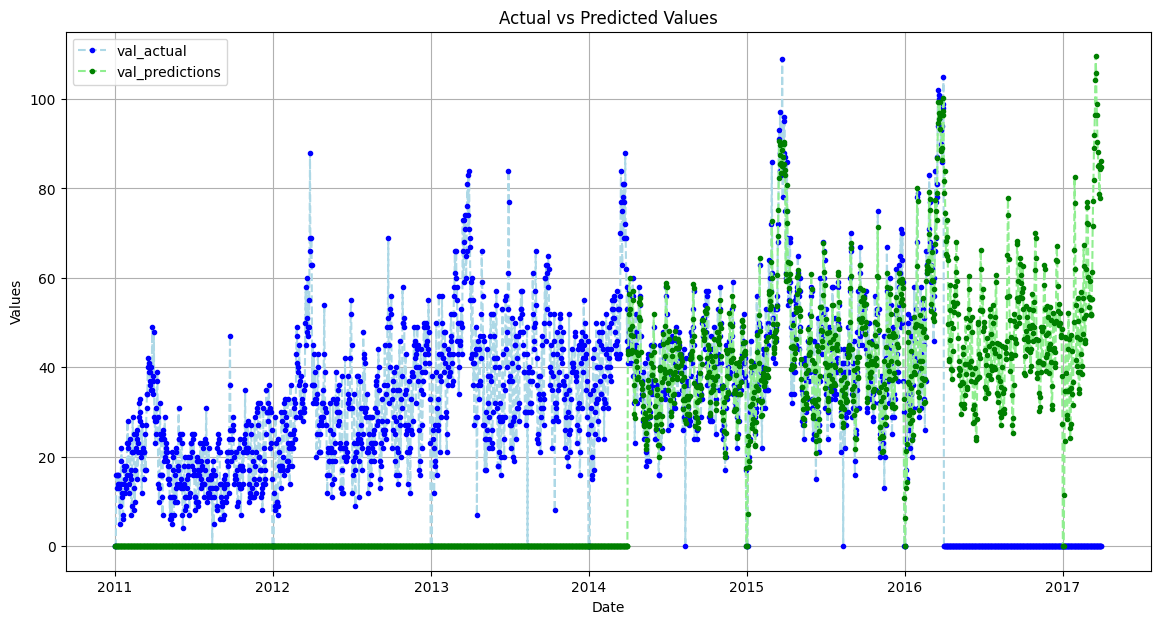

In [85]:
# グラフのサイズを設定
plt.figure(figsize=(14, 7))

# 実際の値（target_true_values）のプロット
plt.plot(valid_df['date'], valid_df['target_true_values'], ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')

# 予測値（test_predictions_padded_df）のプロット
plt.plot(valid_df['date'], valid_df['test_predictions'], ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

# グラフのタイトルとラベル
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')

plt.legend()  # 凡例を表示
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示


In [86]:
# 評価範囲
val_actual1 = valid_df['target_true_values'][1186:1551].values  # 2015年度(365日)
val_actual2 = valid_df['target_true_values'][1551:1917].values  # 2016年度(366日)

val_predictions1 = valid_df['test_predictions'][1186:1551].values  # 予測値をnumpy配列に変換
val_predictions2 = valid_df['test_predictions'][1551:1917].values

# MAEの計算
mae = tf.keras.metrics.MeanAbsoluteError()
val_performance1 = mae(val_actual1, val_predictions1).numpy()
val_performance2 = mae(val_actual2, val_predictions2).numpy()

print(f"Validation MAE 2015: {val_performance1}")
print(f"Validation MAE 2016: {val_performance2}")

Validation MAE 2015: 3.913811206817627
Validation MAE 2016: 4.130071640014648


In [87]:
# インデックスをリセットして連番にする
submit_test_df = valid_df['test_predictions'][-365:].reset_index(drop=True)

# 休業日の実績を0にする
submit_test_df.iloc[137] = 0
submit_test_df.iloc[274] = 0
submit_test_df.iloc[275] = 0
submit_test_df.iloc[276] = 0
submit_test_df.iloc[277] = 0

# DataFrameを作成
df_submit1 = pd.DataFrame({
    'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),  # datetime列
    'y': submit_test_df.reset_index(drop=True)  # 1次元のsubmit_test_dfをそのまま使用
})

In [89]:
# # CSVとして保存
# df_submit1.to_csv("submit_moving32.csv", index=False, header=False)
# df_submit1

,datetime,y
0,2016-04-01,78.989365
1,2016-04-02,81.625908
2,2016-04-03,83.940857
3,2016-04-04,74.470421
4,2016-04-05,68.275940
5,2016-04-06,65.405426
6,2016-04-07,64.872314
7,2016-04-08,69.090309
8,2016-04-09,72.889542
9,2016-04-10,64.022179


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
import tensorflow as tf

# 自己回帰LSTMモデルを定義
def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),  # 最初のLSTM層
        LSTM(32, return_sequences=False),  # 2つ目のLSTM層
        Dense(1, activation='relu')  # 出力層
    ])
    return model

# 'y'列を除いたデータを使う
input_features = train_df.drop(columns=['y']).values  # 特徴量のみ
input_shape = (365, input_features.shape[1])  # 365日分のデータと、特徴量の数
model = create_model(input_shape)

# 自己回帰による予測関数
def predict_autoregressive(model, initial_input, steps=365):
    predictions = []
    current_input = initial_input.copy()

    for _ in range(steps):
        # 現在の入力から1つ予測
        pred = model.predict(current_input[np.newaxis, :, :])
        predictions.append(pred[0, 0])  # 1つの値を追加

        # 自己回帰: 新しい予測値を使って次の入力を作成
        current_input = np.roll(current_input, shift=-1, axis=0)  # 過去を1つずらす
        current_input[-1, -1] = pred  # 新しい予測値を追加

    return np.array(predictions)

# モデルのコンパイルと訓練
def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義
    early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

    # モデルをコンパイル
    model.compile(loss=Huber(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

    # データをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    input_data = []
    target_data = []

    for i in range(len(input_features) - 365):
        input_data.append(input_features[i:i + 365])  # 特徴量のみ
        target_data.append(target_values[i + 365])  # 'y'列のターゲット値

    input_data = np.array(input_data)
    target_data = np.array(target_data)

    # モデルの訓練実行
    history = model.fit(input_data, target_data, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

    return history, input_data  # input_dataも返す

# 'y'列をターゲット値として取得
target_values = train_df['y'].values

# トレーニング実行
history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す

# 自己回帰による予測
initial_input = input_features[-365:]  # 最後の365日分を最初の入力に
predictions = predict_autoregressive(model, initial_input, steps=365)

# 結果を確認
print(predictions)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - loss: 0.0128 - mean_absolute_error: 0.1252
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - loss: 0.0055 - mean_absolute_error: 0.0821
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - loss: 0.0046 - mean_absolute_error: 0.0744
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - loss: 0.0039 - mean_absolute_error: 0.0681
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - loss: 0.0033 - mean_absolute_error: 0.0629
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - loss: 0.0030 - mean_absolute_error: 0.0593
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - loss: 0.0029 - mean_absolute_error: 0.0578
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - loss: 0.0028 - mean_absolute_error: 0.0567
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.0027 - mean_absolute_error: 0.0557
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - loss: 0.0026 - mean_absolute_error: 0.0549
Epoch 11/50
49/49 ━

In [19]:
# test_dfで自己回帰LSTMを使って予測を行う関数
def predict_test_data(model, test_df, window_size=365, steps=365):
    # 最初の365日分のデータを入力として使用
    test_input_features = test_df[-window_size:].values  # 'y'列を除いた特徴量のみ
    predictions = []

    # 自己回帰的に予測を行う
    for _ in range(steps):
        # 現在の入力で予測
        pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
        predictions.append(pred[0, 0])  # 予測値をリストに追加

        # 自己回帰: 新しい予測を次の入力にフィードバック
        test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
        test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

    return np.array(predictions)

# test_dfで予測を実行
test_predictions_scaled = predict_test_data(model, test_df, window_size=365, steps=365)

# 目的変数 'y' だけを逆変換して元のスケールに戻す
test_predictions = scaler_target.inverse_transform(test_predictions_scaled.reshape(-1, 1))

# 予測結果を出力
print("Test data predictions:", test_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [23]:
# test_dfで自己回帰LSTMを使って予測を行う関数
def predict_test_data(model, test_df, window_size=365, total_steps=730, future_steps=365):
    # 最初の365日分のデータを入力として使用
    test_input_features = test_df[-window_size:].values  # 'y'列を除いた特徴量のみ
    predictions = []

    # 自己回帰的に予測を行う (2年分)
    for _ in range(total_steps):  # 残りの2年分 (730日)
        # 現在の入力で予測
        pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
        predictions.append(pred[0, 0])  # 予測値をリストに追加

        # 自己回帰: 新しい予測を次の入力にフィードバック
        test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
        test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

    # さらに未来1年分を予測
    for _ in range(future_steps):  # 未来365日分
        pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
        predictions.append(pred[0, 0])  # 予測値をリストに追加

        # 自己回帰: 新しい予測を次の入力にフィードバック
        test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
        test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

    return np.array(predictions)

# test_dfで予測を実行
# 2年分 (730日) の予測と、さらに1年分の未来予測を実行
test_predictions_scaled = predict_test_data(model, test_df, window_size=365, total_steps=730, future_steps=365)

# 目的変数 'y' だけを逆変換して元のスケールに戻す
test_predictions = scaler_target.inverse_transform(test_predictions_scaled.reshape(-1, 1))

# 予測結果を出力
print("Test data predictions:", test_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/s

In [24]:
# target_true_valuesをPandasのSeriesに変換
target_true_values = pd.Series(scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten())
# インデックスをリセット
target_true_values = target_true_values.reset_index(drop=True)

# 821行に0を追加する（test_predictionsに合わせて次元を調整）
zeros_to_add = np.zeros((1186, test_predictions.shape[1]))  # 821行と同じ列数のゼロを作成
# test_predictionsの先頭に0を追加
test_predictions_padded = np.concatenate([zeros_to_add, test_predictions], axis=0)
# numpy配列をPandasのDataFrameに変換してインデックスをリセット
test_predictions_padded_df = pd.DataFrame(test_predictions_padded).reset_index(drop=True)

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# target_true_values と test_predictions_padded_df の長さを確認
target_true_len = len(target_true_values)
test_predictions_len = len(test_predictions_padded_df)

# データの長さを一致させるための処理
max_len = max(target_true_len, test_predictions_len)

# target_true_values に足りない分は 0 を追加
if target_true_len < max_len:
    target_true_values = pd.Series(np.concatenate([target_true_values.values, np.zeros(max_len - target_true_len)]))

# test_predictions_padded_df の 1 列目に足りない分は 0 を追加
if test_predictions_len < max_len:
    test_predictions_padded_df[0] = pd.Series(np.concatenate([test_predictions_padded_df[0].values, np.zeros(max_len - test_predictions_len)]))

# 1917日分のdate_rangeを作成
start_date = datetime(2011, 1, 1)
date_range = [start_date + timedelta(days=i) for i in range(max_len)]  # max_len 日数の範囲

# DataFrameの作成
valid_df2 = pd.DataFrame({
    'date': date_range,                       # 1列目: 2011年1月1日からの日付
    'target_true_values': target_true_values, # 2列目: 実際の値
    'test_predictions': test_predictions_padded_df[0],  # 3列目: 予測値
    'diff_values': target_true_values - test_predictions_padded_df[0]  # 4列目: 実際の値と予測値の差
})

# 結果を確認
pd.set_option('display.max_rows', None)
valid_df

,date,target_true_values,test_predictions,diff_values
0,2011-01-01,0.0,0.000000,0.000000
1,2011-01-02,0.0,0.000000,0.000000
2,2011-01-03,0.0,0.000000,0.000000
3,2011-01-04,16.0,0.000000,16.000000
4,2011-01-05,16.0,0.000000,16.000000
5,2011-01-06,13.0,0.000000,13.000000
6,2011-01-07,14.0,0.000000,14.000000
7,2011-01-08,16.0,0.000000,16.000000
8,2011-01-09,16.0,0.000000,16.000000
9,2011-01-10,14.0,0.000000,14.000000


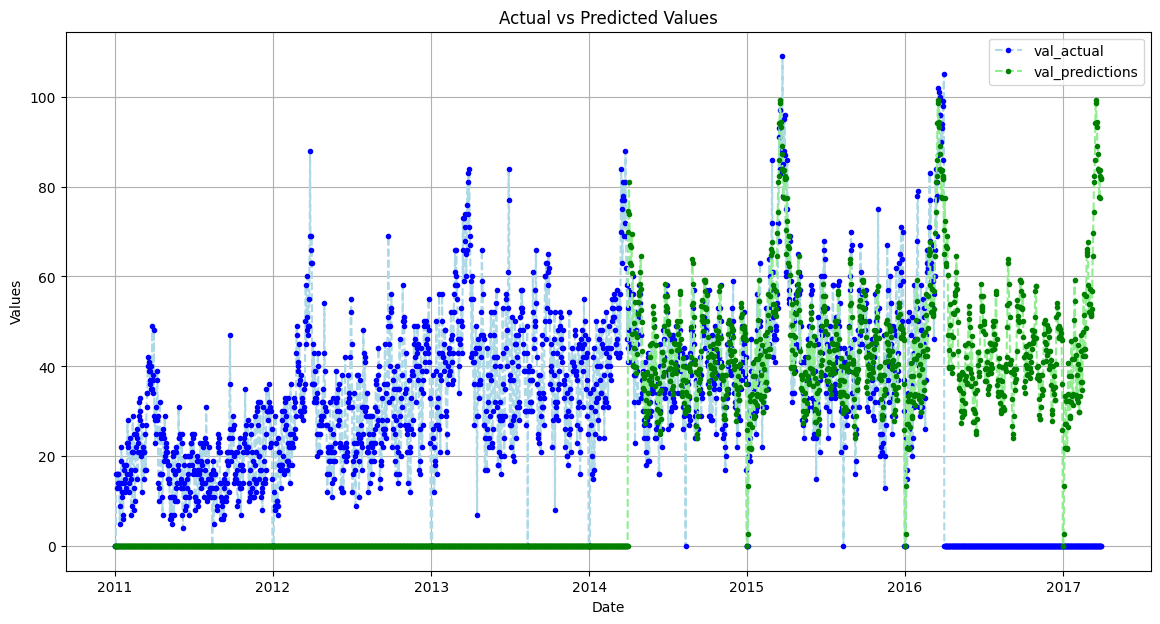

In [26]:
# グラフのサイズを設定
plt.figure(figsize=(14, 7))

# 実際の値（target_true_values）のプロット
plt.plot(valid_df2['date'], valid_df2['target_true_values'], ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')

# 予測値（test_predictions_padded_df）のプロット
plt.plot(valid_df2['date'], valid_df2['test_predictions'], ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

# グラフのタイトルとラベル
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')

plt.legend()  # 凡例を表示
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示


In [27]:
# 評価範囲
val_actual1 = valid_df['target_true_values'][1186:1551].values  # 2015年度(365日)
val_actual2 = valid_df['target_true_values'][1551:1917].values  # 2016年度(366日)

val_predictions1 = valid_df['test_predictions'][1186:1551].values  # 予測値をnumpy配列に変換
val_predictions2 = valid_df['test_predictions'][1551:1917].values

# MAEの計算
mae = tf.keras.metrics.MeanAbsoluteError()
val_performance1 = mae(val_actual1, val_predictions1).numpy()
val_performance2 = mae(val_actual2, val_predictions2).numpy()

print(f"Validation MAE 2015: {val_performance1}")
print(f"Validation MAE 2016: {val_performance2}")

Validation MAE 2015: 9.10991382598877
Validation MAE 2016: 9.13792610168457


In [30]:
# インデックスをリセットして連番にする
submit_test_df2 = valid_df2['test_predictions'][-365:].reset_index(drop=True)

# 休業日の実績を0にする
submit_test_df2.iloc[137] = 0
submit_test_df2.iloc[274] = 0
submit_test_df2.iloc[275] = 0
submit_test_df2.iloc[276] = 0
submit_test_df2.iloc[277] = 0

# DataFrameを作成
df_submit2 = pd.DataFrame({
    'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),  # datetime列
    'y': submit_test_df2.reset_index(drop=True)  # 1次元のsubmit_test_dfをそのまま使用
})

In [31]:
# CSVとして保存
df_submit2.to_csv("submit_moving33.csv", index=False, header=False)
df_submit2

,datetime,y
0,2016-04-01,64.948425
1,2016-04-02,70.366173
2,2016-04-03,77.445473
3,2016-04-04,72.393936
4,2016-04-05,66.768158
5,2016-04-06,62.946121
6,2016-04-07,62.442616
7,2016-04-08,66.422318
8,2016-04-09,68.903038
9,2016-04-10,60.409672
